In [1]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[1]
import sys
sys.path.append(str(PROJECT_ROOT))
from bahamas_lig.utils import *
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import itertools

In [2]:
## Styling
sns.set_palette("viridis", n_colors=6)
sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": u"-.",
    },
)
sns.set_context("talk")

## Load GIA model weights

In [3]:
model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_new"
inference_dir = PROJECT_ROOT / "model_outputs/synthetic_test/"
models_df=get_model_status(inference_dir,model_dir)
models_df=models_df[models_df['Lithosphere']!=99]
models_df['true_model']=False
# true_model = "output_l100VM5-3D"
true_model = "output_new71Cp420_L6G_Wael_T"
models_df.at[true_model,'true_model']=True


In [4]:
model_weights = pd.read_csv(str(inference_dir)+'/'+str('model_weights/model_weights.csv'),index_col=0)

In [5]:
hol_model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_Hol_new"
hol_inference_dir = PROJECT_ROOT / "model_outputs/synthetic_test/holocene"
lig_model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_new"
lig_inference_dir = PROJECT_ROOT / "model_outputs/synthetic_test"
# data_dir = PROJECT_ROOT / "data/"

holocene_dataframe = get_model_status(hol_inference_dir,hol_model_dir)
lig_dataframe = get_model_status(lig_inference_dir,lig_model_dir)


In [6]:
model_predict_dir = str(inference_dir)+'/'+str('pymc3_post_predict_2021')
model_predict_list=[o[:-4] for o in os.listdir(model_predict_dir) if '.pkl' in o]

preds = {}
for f in model_predict_list:
    preds[f]=load(model_predict_dir+'/'+f+'.pkl')
model_weights = pd.read_csv(str(inference_dir)+'/'+str('model_weights/model_weights.csv'),index_col=0)
model_weights=model_weights[~model_weights.index.str.endswith('3D')]

if np.sum(model_weights['weight'])==0:
    model_weights['weight']=1
else:
    model_weights['weight']=model_weights['weight']/np.sum(model_weights['weight'])
gmsl=weighted_trace(preds,model_weights,iters=10000)


model_weights = pd.read_csv(str(inference_dir)+'/'+str('model_weights/model_weights.csv'),index_col=0)
model_weights=model_weights[~model_weights.index.str.endswith('3D')]

model_weights['weight']=1
if np.sum(model_weights['weight'])==0:
    model_weights['weight']=1
else:
    model_weights['weight']=model_weights['weight']/np.sum(model_weights['weight'])
gmsl_flat=weighted_trace(preds,model_weights,iters=10000)

model_weights = pd.read_csv(str(inference_dir)+'/'+str('model_weights/model_weights.csv'),index_col=0)
model_weights['weight']=0

model_weights.at[true_model,'weight']=1
if np.sum(model_weights['weight'])==0:
    model_weights['weight']=1
else:
    model_weights['weight']=model_weights['weight']/np.sum(model_weights['weight'])
gmsl_true=weighted_trace(preds,model_weights,iters=10000)

In [7]:
inferences=[gmsl, gmsl_true, gmsl_flat]

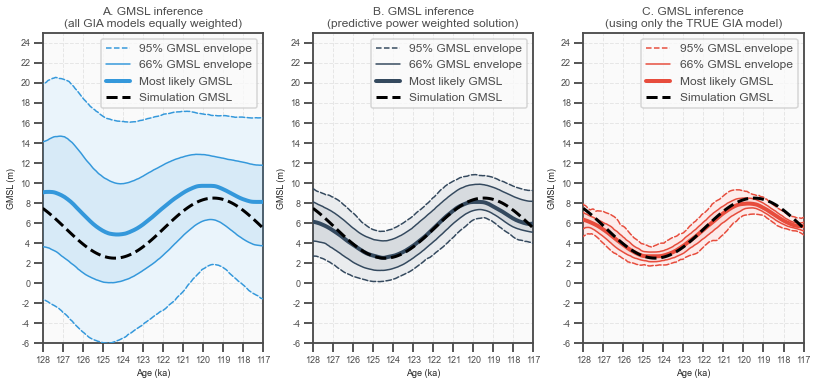

In [8]:
fig = plt.figure(figsize=(9*1.3, 5*1.3))
smoothing = 2
gs = gridspec.GridSpec(2, 5)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cs = sns.color_palette(flatui)
X_new = np.linspace(115, 130, 200)[:, np.newaxis]

## Synthetic GMSL
subsidence = 2.5
lig_start = 128
lig_end = 117
lig_age = np.linspace(lig_start,lig_end,100)
lig_dt = lig_age-lig_end
lig_synth_gmsl = 3 * np.sin(lig_dt / (0.5 * np.pi)) + 3 + subsidence



ax1=plt.subplot(1,3,2)
plot_gmsl_inference(X_new,inferences[0],cs[4],ax1,True)

plt.gca().set_title(
    "B. GMSL inference\n(predictive power weighted solution)",
    fontsize=12,
)

ax2=plt.subplot(1,3,3)
plot_gmsl_inference(X_new,inferences[1],cs[3],ax2,True)


plt.gca().set_title(
    "C. GMSL inference\n(using only the TRUE GIA model)",
    fontsize=12,
)
plt.gca().set_ylabel("GMSL (m)", fontsize=9)
plt.gca().invert_xaxis()

ax3=plt.subplot(1,3,1)
plot_gmsl_inference(X_new,inferences[2],cs[1],ax3,True)

plt.gca().set_title(
    "A. GMSL inference\n(all GIA models equally weighted)", fontsize=12
)



ax1.plot(lig_age, lig_synth_gmsl, label="Simulation GMSL", lw=3, linestyle='--', zorder=30, color='k')
ax2.plot(lig_age, lig_synth_gmsl, label="Simulation GMSL", lw=3, linestyle='--', zorder=30, color='k')
ax3.plot(lig_age, lig_synth_gmsl, label="Simulation GMSL", lw=3, linestyle='--', zorder=30, color='k')

axes = [ax1,ax2,ax3]
c=0
for a in axes:

    a.legend(fontsize=12)
    a.set_xticks(np.arange(114,131))
    a.set_xticklabels(np.arange(114,131,1),fontsize=9)
    a.set_yticks(range(-8,25,2))
    a.set_yticklabels(range(-8,25,2), fontsize=9)
    if not c==1:
        a.set_xlabel("Age (ka)")
    a.set_ylabel("Global Mean Sea Level\n(m above MSL)", fontsize=12)
    a.grid(True,lw=1,linestyle='--')
    
    a.set_xlabel("Age (ka)", fontsize=9)
    a.set_ylabel("GMSL (m)", fontsize=9)

    a.set_ylim([-6, 25])
    a.set_xlim([117, 128])
    a.invert_xaxis()
    a.set_aspect(1/2)
    c+=1
    
fig.tight_layout(w_pad=0.4)
fig.savefig("synthetic_inversion.pdf", bbox_inches="tight", dpi=300)

**Fig. 3.** GMSL inference from the synthetic dataset that differs from the real sea level data analyzed in this paper only in that the elevations were changed to match a prescribed GMSL curve (shown as dashed black line) and a single GIA model. Panel **A** shows the estimated GMSL when all 576 GIA models are considered equally probable. Panel **B** shows the solution where models are weighted by their ability to reproduce the spatial trends across the data (the approach used with the real data in this study). Panel **C** shows the best solution possible if the true GIA in the region was perfectly known.